In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib.util
import sys
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from datetime import datetime
from IPython.display import display  # Jupyter-safe
from io import StringIO
import csv
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import TensorDataset, DataLoader

In [2]:
torch_spec = importlib.util.find_spec("torch")
print(torch_spec)

ModuleSpec(name='torch', loader=<_frozen_importlib_external.SourceFileLoader object at 0x74fef4f965f0>, origin='/home/fadluw/anaconda3/envs/misk/lib/python3.10/site-packages/torch/__init__.py', submodule_search_locations=['/home/fadluw/anaconda3/envs/misk/lib/python3.10/site-packages/torch'])


Params

In [3]:
# Parameters
aligned_data_root = Path("aligned_dataset")
window_size = 70


Load and Accumulate Data Across Trials

In [4]:
# Storage for all trials
X_trials = []
y_trials = []

# Load aligned IMU and angle data from all trials
for trial_dir in sorted(aligned_data_root.glob("trial_*")):
    X_path = trial_dir / "X.csv"
    y_path = trial_dir / "Y.csv"
    if not X_path.exists() or not y_path.exists():
        print(f"Missing data in {trial_dir}, skipping.")
        continue

    X_df = pd.read_csv(X_path)
    y_df = pd.read_csv(y_path)

    # Drop unnecessary columns
    X_df = X_df.drop(columns=['Millis'], errors='ignore')
    y_df = y_df.drop(columns=['time'], errors='ignore')

    assert len(X_df) == len(y_df), f"Length mismatch in {trial_dir}"

    X_trials.append(X_df.values)
    y_trials.append(y_df.values)


 Concatenate

In [5]:
# Concatenate all trials
X_all = np.concatenate(X_trials, axis=0)
y_all = np.concatenate(y_trials, axis=0)

Apply Sliding Window

In [6]:
def create_windows(X, y, window_size):
    X_windowed = []
    y_windowed = []
    for i in range(len(X) - window_size + 1):
        X_windowed.append(X[i:i+window_size])
        y_windowed.append(y[i+window_size-1])  # predict last frame
    return np.array(X_windowed), np.array(y_windowed)

X_all, y_all = create_windows(X_all, y_all, window_size)


Train/Validation/Test Split

In [7]:
# First split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.4, random_state=42
)

# Second split: 20% val, 20% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)


Fitting and Transforming Scalers

In [8]:
# --- Now fit scalers only on training data ---

# Flatten X_train for fitting (because windowed input has shape [samples, window_size, features])
X_train_flat = X_train.reshape(-1, X_train.shape[-1])

scaler_X = StandardScaler().fit(X_train_flat)

# Transform all sets
X_train_scaled = scaler_X.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled   = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled  = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)



Wrap in PyTorch Datasets and Check Shapes

In [9]:
# Wrap in PyTorch datasets
train_dataset = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)
val_dataset = TensorDataset(
    torch.tensor(X_val_scaled, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
)

# Define loss
criterion = nn.MSELoss()

# Wrap test data into a Dataset and DataLoader
test_dataset = TensorDataset(
    torch.tensor(X_test_scaled, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
)


# Sanity check
x0, y0 = train_dataset[0]
print("Sample input shape:", x0.shape)
print("Sample target shape:", y0.shape)


Sample input shape: torch.Size([70, 30])
Sample target shape: torch.Size([24])


In [10]:
X_df

,AccelX_chest,AccelY_chest,AccelZ_chest,GyroX_chest,GyroY_chest,GyroZ_chest,AccelX_right_leg,AccelY_right_leg,AccelZ_right_leg,GyroX_right_leg,...,AccelZ_right_arm,GyroX_right_arm,GyroY_right_arm,GyroZ_right_arm,AccelX_left_arm,AccelY_left_arm,AccelZ_left_arm,GyroX_left_arm,GyroY_left_arm,GyroZ_left_arm
0,-0.974,-0.158,0.247,-4.340,-0.910,-11.060,-0.989,-0.250,0.010,0.000,...,-0.051,-13.580,-6.230,-1.330,-0.797,-0.447,-0.423,-7.350,2.170,-0.140
1,-0.980,-0.165,0.252,-3.792,-1.534,-11.004,-0.984,-0.252,0.011,-0.122,...,-0.042,-12.654,-8.077,0.058,-0.792,-0.451,-0.419,-6.227,2.173,-0.279
2,-0.983,-0.164,0.261,-3.929,-3.166,-10.819,-0.987,-0.245,0.009,-0.190,...,-0.096,-8.432,-8.326,1.572,-0.796,-0.450,-0.426,-4.230,2.706,-0.079
3,-0.979,-0.163,0.258,-4.627,-5.351,-10.670,-0.989,-0.243,0.006,-0.582,...,-0.087,-9.703,-7.385,3.721,-0.807,-0.433,-0.432,-3.994,2.045,-0.338
4,-0.971,-0.178,0.250,-4.464,-6.365,-10.485,-0.988,-0.245,0.005,-0.766,...,-0.047,-10.517,-10.129,3.406,-0.807,-0.419,-0.436,-6.260,0.949,-1.591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8667,-0.940,-0.069,0.031,-6.115,-1.804,4.283,-0.969,-0.289,-0.103,-9.457,...,-0.168,-14.638,4.156,-17.374,-0.763,0.152,-0.485,8.219,28.189,29.638
8668,-0.944,-0.091,0.038,2.332,-5.765,2.600,-0.926,-0.299,-0.056,-3.912,...,-0.173,-16.731,0.340,-8.773,-0.792,0.125,-0.455,12.960,20.106,34.967
8669,-0.967,-0.112,0.054,9.001,-8.268,2.011,-0.921,-0.247,-0.058,-6.688,...,-0.175,-15.440,-1.678,-0.449,-0.754,0.192,-0.370,23.668,15.518,38.936
8670,-0.995,-0.118,0.066,13.113,-8.690,1.190,-0.944,-0.206,-0.138,-11.573,...,-0.191,-10.556,-1.145,9.450,-0.721,0.279,-0.408,20.761,21.690,34.221


In [11]:
y_df

,right ankle,left ankle,right knee,left knee,right hip,left hip,right shoulder,left shoulder,right elbow,left elbow,...,right thigh,left thigh,pelvis,trunk,shoulders,head,right arm,left arm,right forearm,left forearm
0,38.866456,68.533373,7.446345,5.135329,2.958860,3.836582,9.499746,8.100783,6.346643,7.807354,...,82.818647,81.940925,2.390685,93.411106,0.944986,85.548986,76.277761,77.676724,82.624404,85.484078
1,38.343883,67.663694,7.098845,5.211061,2.763779,3.813969,9.576901,7.943975,6.655394,8.003499,...,82.907602,81.857412,2.413493,93.304981,0.619276,85.720766,76.094480,77.727406,82.749874,85.730905
2,38.564056,68.091949,7.233265,5.214349,2.744306,3.736667,9.660954,7.744906,6.794059,8.090523,...,82.852892,81.860531,2.423980,93.230797,0.349706,85.798934,75.936244,77.852291,82.730303,85.942814
3,38.867967,68.663526,7.427086,5.242732,2.715914,3.650176,9.714999,7.533809,6.846494,8.130385,...,82.788269,81.854007,2.426682,93.137782,0.094621,85.755406,75.789184,77.970374,82.635678,86.100759
4,39.087929,69.071104,7.536546,5.309117,2.611634,3.531403,9.696660,7.321739,6.858430,8.130518,...,82.750948,81.831179,2.425955,92.996181,0.150368,85.646848,75.665922,78.040843,82.524352,86.171361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8667,22.447342,112.239972,171.256313,1.126398,1.881603,10.083178,171.149280,20.528434,1.165087,163.820070,...,89.796738,77.831958,5.459484,95.548735,8.988479,77.853373,79.064415,67.386702,102.100672,96.433369
8668,21.076632,110.995887,170.776155,1.102184,2.075384,10.120379,171.373276,20.247536,1.522086,163.778250,...,89.859490,77.663727,5.402113,95.417706,8.997585,77.754060,79.157382,67.536570,102.364704,96.241680
8669,19.904360,110.256706,170.460445,1.145937,2.330769,10.171159,171.497385,19.793236,1.620868,163.971346,...,89.967538,77.465611,5.350489,95.270369,8.890905,77.469419,79.134155,67.843534,102.486713,96.127812
8670,19.493500,110.451691,170.350326,1.182926,2.539074,10.227793,171.468768,19.225188,1.432229,164.510639,...,90.069378,77.302511,5.310810,95.163903,8.632980,77.080014,78.999072,68.305116,102.433158,96.205523


# Model

Model Definition

In [12]:
import torch.nn as nn

class IMULSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, fc_hidden_size=64):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, output_size)

        self.output_activation = nn.Sigmoid()  # <-- Add this

    def forward(self, x):
        batch_size = x.size(0)
        out, _ = self.lstm(x)
        x = out[:, -1, :]  # last time step
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        x = self.output_activation(x)  # <-- Apply Sigmoid
        return x * 180.0  # <-- Scale output to [0, 180]


Logging Setup

In [13]:
# Setup log directory
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
log_dir = os.path.join('logs', f'run_{timestamp}')
os.makedirs(log_dir, exist_ok=True)

LOG_PATH = os.path.join(log_dir, 'training_log.txt')
csv_path = os.path.join(log_dir, 'metrics.csv')
SAVE_STDOUT = True  # If True, also print to terminal


CSV Logging Setup

In [14]:
# Metrics CSV setup
csv_fields = ['epoch', 'train_mse', 'train_mae', 'train_rmse', 'train_r2',
              'val_mse', 'val_mae', 'val_rmse', 'val_r2']

csv_file = open(csv_path, mode='w', newline='')
csv_writer = csv.DictWriter(csv_file, fieldnames=csv_fields)
csv_writer.writeheader()


79

In [15]:
print("Target sample shape:", train_dataset[0][1].shape)


Target sample shape: torch.Size([24])


Logger Class

In [16]:
class DualLogger:
    def __init__(self, filepath, print_to_stdout=True):
        self.log_file = open(filepath, 'w')
        self.print_to_stdout = print_to_stdout

    def log(self, text):
        self.log_file.write(text + '\n')
        self.log_file.flush()
        if self.print_to_stdout:
            print(text)

    def close(self):
        self.log_file.close()

logger = DualLogger(LOG_PATH, print_to_stdout=SAVE_STDOUT)


Hyperparameters and Summary

In [17]:
# Hyperparameters
hidden_size = 256
num_layers = 2
batch_size = 70
epochs = 50
learning_rate = 1e-3

# Show config info
print("=" * 70)
print(f"Training started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
print(f"Hyperparameters:")
print(f"  Hidden Size   = {hidden_size}")
print(f"  Num Layers    = {num_layers}")
print(f"  Batch Size    = {batch_size}")
print(f"  Epochs        = {epochs}")
print(f"  Learning Rate = {learning_rate}")
print(f"  Window Size   = {window_size}")
print("=" * 70)

# Save config to file
hyperparams = {
    "hidden_size": hidden_size,
    "num_layers": num_layers,
    "batch_size": batch_size,
    "epochs": epochs,
    "learning_rate": learning_rate,
    "window_size": window_size,
}
with open(os.path.join(log_dir, 'hyperparameters.json'), 'w') as f:
    json.dump(hyperparams, f, indent=2)


Training started: 2025-04-30 08:37:05
Device: CUDA
Hyperparameters:
  Hidden Size   = 256
  Num Layers    = 2
  Batch Size    = 70
  Epochs        = 50
  Learning Rate = 0.001
  Window Size   = 70


Model, Optimizer, Dataloaders

In [18]:
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Model setup
input_size = train_dataset[0][0].shape[1]
output_size = train_dataset[0][1].shape[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = IMULSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
mse_loss_fn = nn.MSELoss()
mae_loss_fn = nn.L1Loss()
# ── Log model architecture ───────────────────────────────
arch_path = os.path.join(log_dir, 'model_architecture.txt')
with open(arch_path, 'w') as f:
    f.write(str(model))
print(f"✅ Saved model architecture to: {arch_path}")


✅ Saved model architecture to: logs/run_2025-04-30_08-37-05/model_architecture.txt


Training Loop

In [19]:
# --- Clean Training Loop ---
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

logger.log(f"\nStarting training for {epochs} epochs...\n")

# Early stopping parameters
early_stopping_patience = 10
best_val_loss = np.inf
epochs_without_improvement = 0

for epoch in range(epochs):
    # --- TRAINING PASS ---
    model.train()
    batch_train_preds = []
    batch_train_trues = []

    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        Xb = X_batch.to(device)
        yb = y_batch.to(device)

        preds = model(Xb)

        loss = mse_loss_fn(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_train_preds.append(preds.detach().cpu())
        batch_train_trues.append(yb.detach().cpu())

        if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(train_loader):
            avg_batch_loss = loss.item()
            logger.log(f"  Batch {batch_idx+1:>4}/{len(train_loader)} – Scaled MSE Loss: {avg_batch_loss:.4f}")

    # --- EPOCH TRAIN METRICS ---
    epoch_train_targets = torch.cat(batch_train_trues).numpy()
    epoch_train_preds   = torch.cat(batch_train_preds).numpy()



    mse_train = mean_squared_error(epoch_train_targets.ravel(), epoch_train_preds.ravel())
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(epoch_train_targets.ravel(), epoch_train_preds.ravel())
    r2_train = r2_score(epoch_train_targets.ravel(), epoch_train_preds.ravel())

    # --- VALIDATION PASS ---
    model.eval()
    batch_val_preds = []
    batch_val_trues = []

    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            Xv = X_val_batch.to(device)
            yv = y_val_batch.to(device)

            preds = model(Xv)

            batch_val_preds.append(preds.cpu())
            batch_val_trues.append(yv.cpu())

    epoch_val_targets = torch.cat(batch_val_trues).numpy()
    epoch_val_preds   = torch.cat(batch_val_preds).numpy()



    mse_val = mean_squared_error(epoch_val_targets.ravel(), epoch_val_preds.ravel())
    rmse_val = np.sqrt(mse_val)
    mae_val = mean_absolute_error(epoch_val_targets.ravel(), epoch_val_preds.ravel())
    r2_val = r2_score(epoch_val_targets.ravel(), epoch_val_preds.ravel())

    # --- LOG METRICS ---
    logger.log(f"Epoch {epoch+1}/{epochs}")
    logger.log(f"  ↳ Train (deg) → MSE: {mse_train:.2f}, MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}°, R²: {r2_train:.4f}")
    logger.log(f"  ↳ Val   (deg) → MSE: {mse_val:.2f}, MAE: {mae_val:.2f}, RMSE: {rmse_val:.2f}°, R²: {r2_val:.4f}")
    logger.log("-" * 70)

    csv_writer.writerow({
        'epoch': epoch + 1,
        'train_mse': mse_train,
        'train_mae': mae_train,
        'train_rmse': rmse_train,
        'train_r2': r2_train,
        'val_mse': mse_val,
        'val_mae': mae_val,
        'val_rmse': rmse_val,
        'val_r2': r2_val,
    })
    csv_file.flush()

    # --- EARLY STOPPING CHECK ---
    if mse_val < best_val_loss:
        best_val_loss = mse_val
        epochs_without_improvement = 0
        best_model_state = model.state_dict()
    else:
        epochs_without_improvement += 1
        logger.log(f"  ↳ No improvement for {epochs_without_improvement} consecutive epochs.")

    if epochs_without_improvement >= early_stopping_patience:
        logger.log(f"Early stopping triggered after {epoch+1} epochs (patience {early_stopping_patience}).")
        break

# --- AFTER TRAINING ---
csv_file.close()
logger.close()

# Save the best model state
model.load_state_dict(best_model_state)



Starting training for 50 epochs...

  Batch  100/784 – Scaled MSE Loss: 1982.8263
  Batch  200/784 – Scaled MSE Loss: 1876.0314
  Batch  300/784 – Scaled MSE Loss: 2053.5732
  Batch  400/784 – Scaled MSE Loss: 1901.7281
  Batch  500/784 – Scaled MSE Loss: 1598.4137
  Batch  600/784 – Scaled MSE Loss: 1517.0583
  Batch  700/784 – Scaled MSE Loss: 1448.8340
  Batch  784/784 – Scaled MSE Loss: 1157.0070
Epoch 1/50
  ↳ Train (deg) → MSE: 1796.48, MAE: 28.51, RMSE: 42.38°, R²: 0.3050
  ↳ Val   (deg) → MSE: 1284.26, MAE: 22.74, RMSE: 35.84°, R²: 0.5041
----------------------------------------------------------------------
  Batch  100/784 – Scaled MSE Loss: 1015.8168
  Batch  200/784 – Scaled MSE Loss: 1081.3676
  Batch  300/784 – Scaled MSE Loss: 1055.7422
  Batch  400/784 – Scaled MSE Loss: 974.5352
  Batch  500/784 – Scaled MSE Loss: 821.2353
  Batch  600/784 – Scaled MSE Loss: 643.4750
  Batch  700/784 – Scaled MSE Loss: 817.3218
  Batch  784/784 – Scaled MSE Loss: 741.3361
Epoch 2/50
 

<All keys matched successfully>

Target Distribution Inspection

In [20]:
# Inspect target (y) distribution in training and validation sets
train_y = train_dataset[:][1]
val_y = val_dataset[:][1]

print("Train y mean/std:", train_y.mean().item(), train_y.std().item())
print("Val   y mean/std:", val_y.mean().item(), val_y.std().item())
print("Train y min/max:", train_y.min().item(), train_y.max().item())
print("Val   y min/max:", val_y.min().item(), val_y.max().item())


Train y mean/std: 72.06439208984375 50.8406867980957
Val   y mean/std: 72.19798278808594 50.890960693359375
Train y min/max: 0.0 180.0
Val   y min/max: 0.0 179.99978637695312


Save Model Weights

In [21]:
# Save the trained model weights
weights_path = os.path.join(log_dir, "model_weights.pth")
torch.save(model.state_dict(), weights_path)

Setup for Test Evaluation

In [22]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Run Test Evaluation


📝 First 5 Samples: Predicted vs Actual (Degrees)

Sample 1:
  Actual   : [5.1150e+01 6.8670e+01 5.5000e-01 2.9100e+00 1.7384e+02 1.7092e+02
 1.4450e+01 1.5909e+02 5.5400e+00 9.2400e+00 5.1510e+01 6.8480e+01
 9.0360e+01 8.9810e+01 8.9810e+01 8.6890e+01 1.4000e-01 9.2890e+01
 4.0600e+00 9.9130e+01 8.1520e+01 7.5060e+01 8.7060e+01 8.4300e+01]
  Predicted: [ 49.06  66.54   1.1    0.62 171.98 173.45  17.65 161.78   5.97  11.33
  51.7   66.66  88.95  90.91  89.18  88.41   0.95  91.51   2.93  93.61
  82.08  80.61  86.13  81.27]
----------------------------------------------------------------------
Sample 2:
  Actual   : [ 49.14 120.53 178.83   1.41   7.47   7.88   4.79 175.28  24.36 154.4
  46.44  56.6   92.71  92.87  86.12  85.72   5.5   85.13   1.92  83.33
  88.8   91.13 113.17 114.47]
  Predicted: [ 47.08 118.46 173.46   4.43   7.62   7.99   5.4  174.86  27.91 156.26
  48.11  60.11  92.8   92.57  82.64  85.11   4.2   82.95   3.97  81.64
  86.49  88.84 113.31 118.01]
----------------------

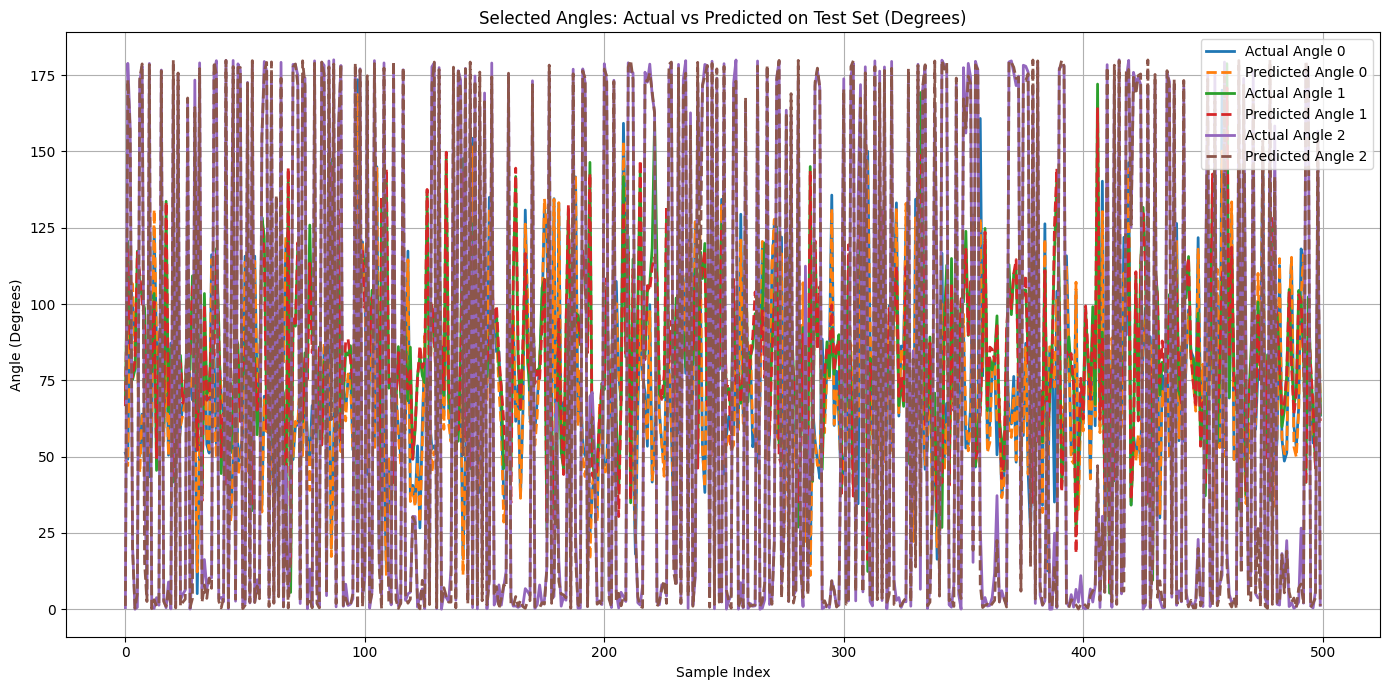

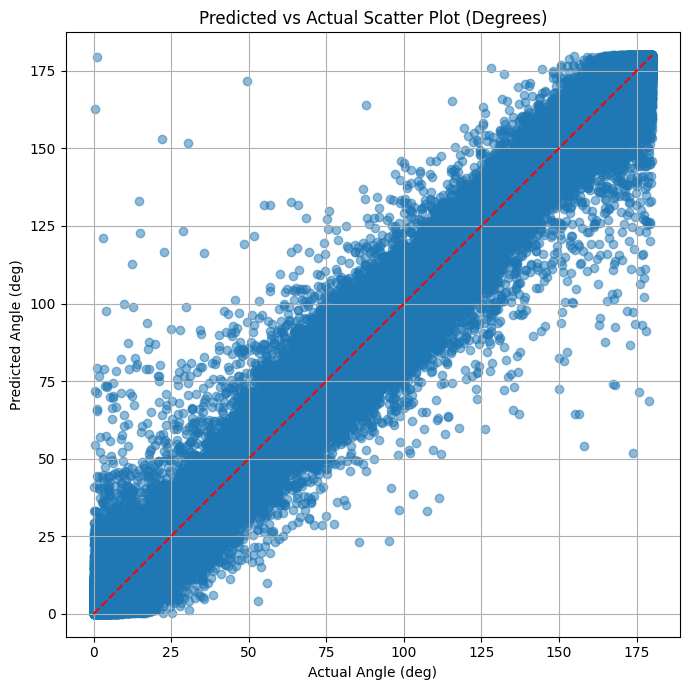

In [ ]:
# --- Imports ---
import torch
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Evaluation Setup ---
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        Xb = X_batch.to(device)
        yb = y_batch.to(device)

        preds = model(Xb)

        all_preds.append(preds.cpu())
        all_targets.append(yb.cpu())

# --- Concatenate Predictions and Targets ---
y_true = torch.cat(all_targets, dim=0).numpy()
y_pred = torch.cat(all_preds, dim=0).numpy()



# --- Print First 5 Samples (Degrees) ---
print("\n📝 First 5 Samples: Predicted vs Actual (Degrees)\n")
for i in range(min(5, len(y_true))):
    print(f"Sample {i+1}:")
    print(f"  Actual   : {np.round(y_true[i], 2)}")
    print(f"  Predicted: {np.round(y_pred[i], 2)}")
    print("-" * 70)

# --- Compute Metrics ---


# Degree-space metrics
mse_deg = mean_squared_error(y_true.ravel(), y_pred.ravel())
rmse_deg = np.sqrt(mse_deg)
mae_deg = mean_absolute_error(y_true.ravel(), y_pred.ravel())
r2_deg = r2_score(y_true.ravel(), y_pred.ravel())

# --- Print Metrics ---
print(f"\n📏 Degree-space Metrics:")
print(f"  MSE  : {mse_deg:.2f}°")
print(f"  MAE  : {mae_deg:.2f}°")
print(f"  RMSE : {rmse_deg:.2f}°")
print(f"  R²   : {r2_deg:.4f}")

# --- Save Metrics ---
metrics = {
    "deg_mse": mse_deg,
    "deg_rmse": rmse_deg,
    "deg_mae": mae_deg,
    "deg_r2": r2_deg
}
df_metrics = pd.DataFrame([metrics])
csv_path = os.path.join(log_dir, "test_metrics.csv")
df_metrics.to_csv(csv_path, index=False)
print(f"\n✅ Saved test metrics to: {csv_path}")

# --- Plot Actual vs Predicted (Degrees) ---
n_samples = min(500, len(y_true))
num_dims_to_plot = min(3, y_true.shape[1])

plt.figure(figsize=(14, 7))
for dim in range(num_dims_to_plot):
    plt.plot(y_true[:n_samples, dim], label=f'Actual Angle {dim}', linewidth=2)
    plt.plot(y_pred[:n_samples, dim], label=f'Predicted Angle {dim}', linestyle='--', linewidth=2)

plt.title('Selected Angles: Actual vs Predicted on Test Set (Degrees)')
plt.xlabel('Sample Index')
plt.ylabel('Angle (Degrees)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Scatter Plot (Predicted vs Actual in Degrees) ---
plt.figure(figsize=(7, 7))
plt.scatter(y_true.ravel(), y_pred.ravel(), alpha=0.5)
plt.plot(
    [y_true.min(), y_true.max()],
    [y_true.min(), y_true.max()],
    'r--'
)

plt.title('Predicted vs Actual Scatter Plot (Degrees)')
plt.xlabel('Actual Angle (deg)')
plt.ylabel('Predicted Angle (deg)')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


Convert Test Outputs to NumPy (Optional for Analysis/Plotting)

In [24]:
# Convert predictions and targets to NumPy for visualization or metrics
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

In [25]:
print(all_preds.shape, all_targets.shape)



(18293, 24) (18293, 24)


✅ Best joints (lowest RMSE):
          Joint        MSE      RMSE       MAE        R2
16       pelvis   4.862339  2.205071  1.685237  0.811798
18    shoulders   7.633478  2.762875  2.037329  0.976488
17        trunk   9.722757  3.118134  2.242798  0.974993
15   left thigh  13.193891  3.632340  2.696920  0.914230
14  right thigh  13.276253  3.643659  2.627311  0.917544

⚠️ Worst joints (highest RMSE):
            Joint        MSE      RMSE       MAE        R2
7   left shoulder  33.230831  5.764619  3.862402  0.992791
0     right ankle  34.718712  5.892259  3.640152  0.958462
9      left elbow  39.160156  6.257808  4.054994  0.992222
22  right forearm  39.582001  6.291423  4.291770  0.963436
23   left forearm  42.809204  6.542874  4.560257  0.961683


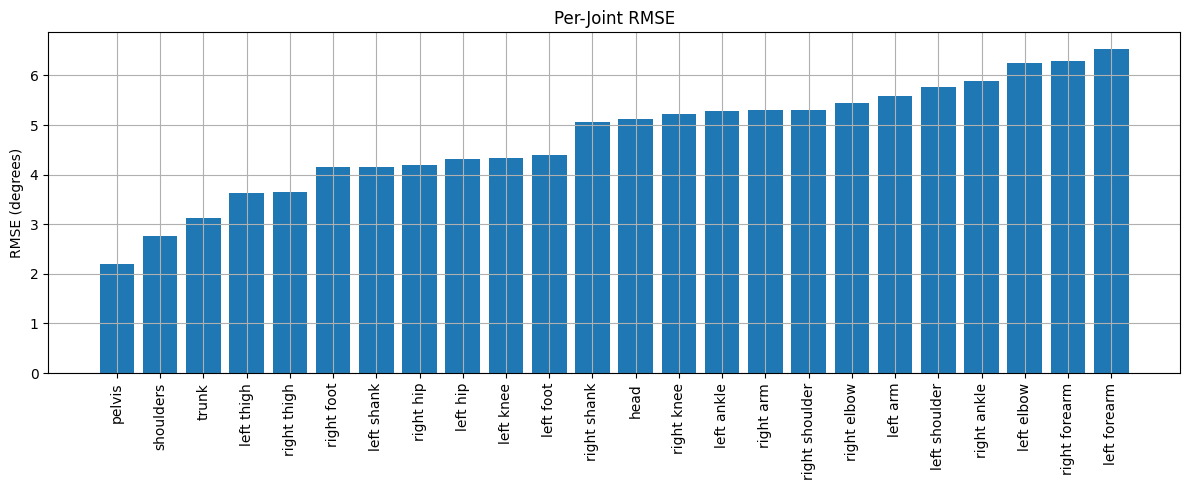

✅ Plot saved to: logs/run_2025-04-30_08-37-05/per_joint_rmse.png


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch

# --- Step 0: Ensure tensors in all_preds and all_targets ---
all_preds = [torch.as_tensor(p) if isinstance(p, np.ndarray) else p for p in all_preds]
all_preds = [p.view(1, -1) if p.ndim == 1 else p for p in all_preds]

all_targets = [torch.as_tensor(t) if isinstance(t, np.ndarray) else t for t in all_targets]
all_targets = [t.view(1, -1) if t.ndim == 1 else t for t in all_targets]

# --- Step 1: Concatenate tensors ---
y_pred_tensor = torch.cat(all_preds, dim=0)
y_true_tensor = torch.cat(all_targets, dim=0)

# --- Step 2: Inverse transform to original scale ---
y_pred = y_pred_tensor.numpy()
y_true = y_true_tensor.numpy()


# --- Step 3: Compute per-joint errors ---
n_joints = y_true.shape[1]
mse_list = []
rmse_list = []
mae_list = []
r2_list = []

for i in range(n_joints):
    mse = mean_squared_error(y_true[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    r2 = r2_score(y_true[:, i], y_pred[:, i])

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

# --- Step 4: Organize into DataFrame ---
joint_names = [
    "right ankle", "left ankle", "right knee", "left knee", "right hip", "left hip",
    "right shoulder", "left shoulder", "right elbow", "left elbow",
    "right foot", "left foot", "right shank", "left shank",
    "right thigh", "left thigh", "pelvis", "trunk", "shoulders", "head",
    "right arm", "left arm", "right forearm", "left forearm"
]

joint_errors = pd.DataFrame({
    "Joint": joint_names,
    "MSE": mse_list,
    "RMSE": rmse_list,
    "MAE": mae_list,
    "R2": r2_list
}).sort_values(by="RMSE")

# --- Step 5: Display best/worst joints ---
print("✅ Best joints (lowest RMSE):")
print(joint_errors.head(5))
print("\n⚠️ Worst joints (highest RMSE):")
print(joint_errors.tail(5))

# --- Step 6: Plot RMSE ---
plt.figure(figsize=(12, 5))
plt.bar(joint_errors["Joint"], joint_errors["RMSE"])
plt.xticks(rotation=90)
plt.ylabel("RMSE (degrees)")
plt.title("Per-Joint RMSE")
plt.grid(True)
plt.tight_layout()

os.makedirs(log_dir, exist_ok=True)
plot_path = os.path.join(log_dir, "per_joint_rmse.png")
plt.savefig(plot_path, dpi=300)
plt.show()

print(f"✅ Plot saved to: {plot_path}")


PLOTS

✅ Saved: training_validation_metrics.png


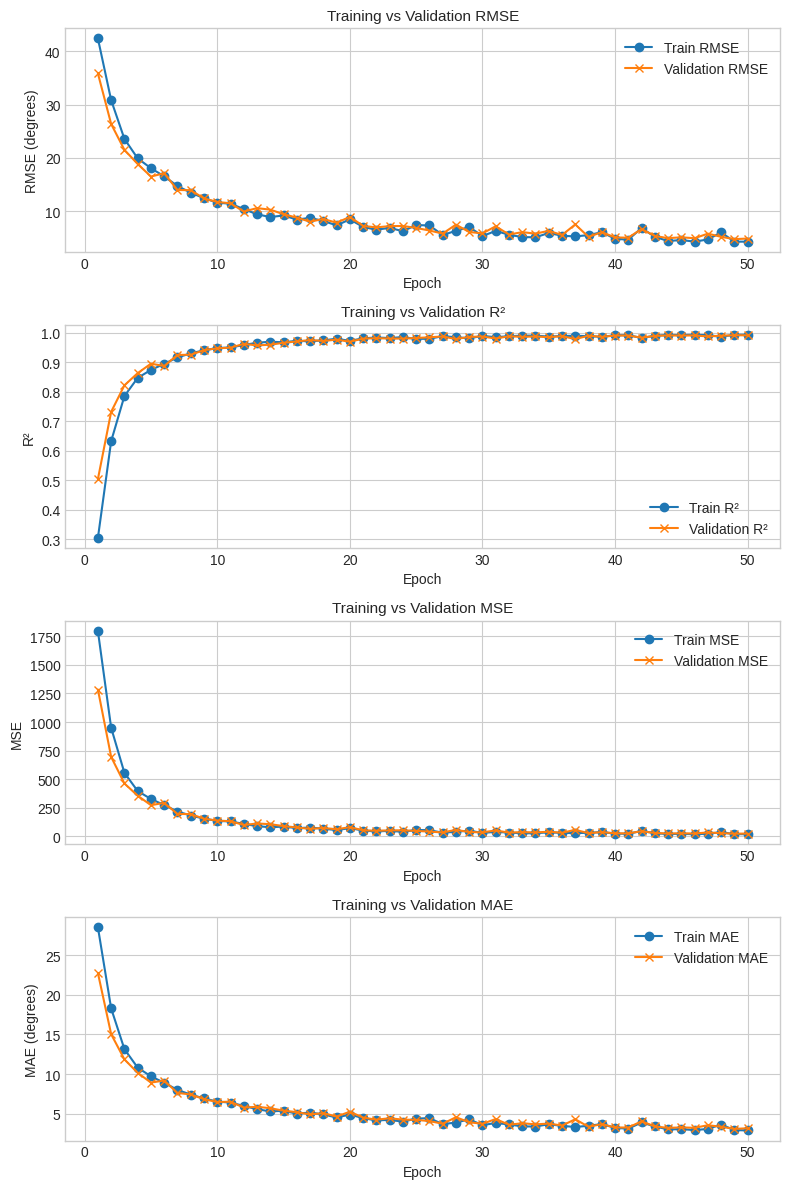

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load Metrics CSV ---
metrics_path = log_dir  # Adjust path if needed
metrics_csv = os.path.join(metrics_path, 'metrics.csv')
df = pd.read_csv(metrics_csv)

# --- Plot Configuration ---
plt.style.use("seaborn-v0_8-whitegrid")  # for Matplotlib 3.6+

fig, axs = plt.subplots(4, 1, figsize=(8, 12))

metrics = [
    ("train_rmse", "val_rmse", "RMSE"),
    ("train_r2", "val_r2", "R²"),
    ("train_mse", "val_mse", "MSE"),
    ("train_mae", "val_mae", "MAE")
]

for idx, (train_col, val_col, label) in enumerate(metrics):
    axs[idx].plot(df["epoch"], df[train_col], label=f"Train {label}", marker='o')
    axs[idx].plot(df["epoch"], df[val_col], label=f"Validation {label}", marker='x')
    axs[idx].set_title(f"Training vs Validation {label}", fontsize=11)
    axs[idx].set_xlabel("Epoch")
    if (label == "RMSE" or label == "MAE"):
       axs[idx].set_ylabel(label+" (degrees)")
    else: 
        axs[idx].set_ylabel(label)
    axs[idx].legend()
    axs[idx].grid(True)

plt.tight_layout()

# --- Save Plots ---
fig.savefig(os.path.join(log_dir,"training_validation_metrics.png"), dpi=300)

print("✅ Saved: training_validation_metrics.png")
